### 1. Datasets

In [7]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

p = lambda x : f'../../data/tables/{x}'

Firslty we name the datasets as the following,
1. CFP = Consumer Fraud Probability
2. MFP = Merchant Fraud Probability

Finally we construct the full `transact` dataset by joining all `transactions` dataset with `CFP` and `MFP`

In [8]:
CFP = spark.read.csv(p('consumer_fraud_probability.csv'), header=True)
MFP = spark.read.csv(p('merchant_fraud_probability.csv'), header=True)
# merchants = spark.read.parquet(p('tbl_merchants.parquet'), header=True)
# consumers = spark.read.parquet(p('consumer_user_details.parquet'), header=True)

transactions = ['transactions_20210228_20210827_snapshot', 
    'transactions_20210828_20220227_snapshot',
    'transactions_20220228_20220828_snapshot']

transacts = None
for t in transactions:
    print(t)
    # if transacts is None:
    #     transacts = spark.read.parquet(p(t), header=True) 
    # else:
    #     transacts = transacts.union(spark.read.parquet(p(t), header=True))

# 1. Join Consumer Fraud Data
transacts = transacts.join(CFP, ['user_id', 'order_datetime'])\
    .withColumn('fraud_probability', F.col('fraud_probability')/100)\
    .withColumnRenamed('fraud_probability', 'consumer_fraud_probability')

# 2. Join Consumer Fraud Data 
transacts = transacts.join(MFP, ['merchant_abn', 'order_datetime'])\
    .withColumn('fraud_probability', F.col('fraud_probability')/100)\
    .withColumnRenamed('fraud_probability', 'merchant_fraud_probability')

# 3. Drop irrelavent `order_id`
transacts = transacts.drop('order_id')

print('count:', transacts.count())
transacts.limit(5)

count: 440


merchant_abn,order_datetime,user_id,dollar_value,consumer_fraud_probability,merchant_fraud_probability
91880575299,2021-04-17,3101,105193.88578925544,0.9142192091901348,0.3299497823665355
83199298021,2021-03-25,19453,13887.358607198637,0.24695211222609117,0.6908556869902988
83199298021,2021-03-25,2550,37808.99908305577,0.5587683298736464,0.6908556869902988
90568944804,2021-11-26,15062,1808.2390827390088,0.1331248894047707,0.28583030842180734
39649557865,2021-11-26,161,1523.9317579642068,0.08575688231609879,0.28690204286050613


We do not know which `user` transacted with which `merchant`. Thus we the fraud probabilities describe **prior distribution**.
Lets use the prior probabilities to calculate the `expected_fraud_transactions` for both `user` and `merchant`.

In [9]:
transacts = transacts.withColumn('E[consumer_fraud_transaction]', F.col('consumer_fraud_probability') * F.col('dollar_value'))
# transacts = transacts.withColumn('E[merchant_fraud_transaction]', F.col('merchant_fraud_probability') * F.col('dollar_value'))

# tdf = transacts.toPandas()
transacts.limit(10)

merchant_abn,order_datetime,user_id,dollar_value,consumer_fraud_probability,merchant_fraud_probability,E[consumer_fraud_transaction]
91880575299,2021-04-17,3101,105193.88578925544,0.9142192091901348,0.3299497823665355,96170.27107789046
83199298021,2021-03-25,19453,13887.358607198637,0.24695211222609117,0.6908556869902988,3429.512541288891
83199298021,2021-03-25,2550,37808.99908305577,0.5587683298736464,0.6908556869902988,21126.471271833303
90568944804,2021-11-26,15062,1808.2390827390088,0.1331248894047707,0.28583030842180734,240.72162790701458
39649557865,2021-11-26,161,1523.9317579642068,0.08575688231609879,0.28690204286050613,130.68763642550203
27093785141,2021-11-26,382,382.02632601680403,0.14593111223510344,0.2758235777292768,55.749526658722445
82368304209,2021-11-26,15335,2922.5523638703216,0.09352974283066866,0.33494431270060276,273.34557100195394
82368304209,2021-11-26,15426,3372.9140889161067,0.12590473225618234,0.33494431270060276,424.6658452880876
21439773999,2021-11-26,575,101.23273218573273,0.20182166627670511,0.28504479048104586,20.430958691468014
21439773999,2021-11-26,948,320.76153584457956,0.16332171185676703,0.28504479048104586,52.38732313194247


In [10]:
transacts.where(F.col('merchant_abn') == 11149063370)

merchant_abn,order_datetime,user_id,dollar_value,consumer_fraud_probability,merchant_fraud_probability,E[consumer_fraud_transaction]
11149063370,2021-11-14,5965,43965.46355720679,0.6937164467869052,0.5240780332276477,30499.565160244667
11149063370,2021-11-14,5965,43965.46355720679,0.6937164467869052,0.5240780332276477,30499.565160244667
11149063370,2021-08-28,230,47346.113374357374,0.8628328808934151,0.5643761254995139,40851.78340190303
11149063370,2021-08-28,230,47346.113374357374,0.8628328808934151,0.5643761254995139,40851.78340190303
11149063370,2022-02-25,17900,42797.34835914282,0.9273262811161372,0.5101538421455242,39687.105895515735
11149063370,2022-02-25,17900,42797.34835914282,0.9273262811161372,0.5101538421455242,39687.105895515735


### 2. Visualisations
We aim to understand the distribution of `E[consumer_fraud_transaction]` and `E[merchant_fraud_transaction]`, along with
`consumer_fraud_probability` and `merchant_fraud_probability`; as then we can identify which transactions are statistically significant, ultimately removing eliminating those merchants.

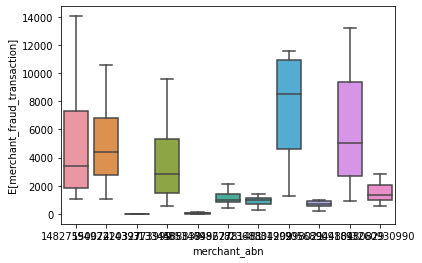

In [5]:
import seaborn as sns

counts = tdf.groupby('merchant_abn').count()['merchant_fraud_probability']
abn = counts[counts > 10].keys()

plot = sns.boxplot(data=tdf[tdf['merchant_abn'].isin(abn)], x = 'merchant_abn', y = 'E[consumer_fraud_transaction]', showfliers = False)
plot.get_figure().clf() # this clears the figure
plot = sns.boxplot(data=tdf[tdf['merchant_abn'].isin(abn)], x = 'merchant_abn', y = 'E[merchant_fraud_transaction]', showfliers = False)

In [6]:
# money = 
tdf.groupby(['merchant_abn', 'order_datetime'])['dollar_value'].sum()

merchant_abn  order_datetime
11149063370   2021-08-28         94692.226749
              2021-11-14         87930.927114
              2022-02-25         85594.696718
11590404675   2021-12-21         51807.721862
14530561097   2021-09-15         92002.278039
                                    ...      
94493496784   2021-11-26          1097.371480
96680767841   2021-11-26          2040.441937
97217894162   2022-01-21         90532.204439
97884414539   2021-10-19         89230.045042
99989036621   2021-10-17        113104.788886
Name: dollar_value, Length: 102, dtype: float64